In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7922.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_33905.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_15492.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_16642.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_37288.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_9357.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_40104.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_1

In [2]:
from fastai.vision.all import *
path = Path('/kaggle/input/planets-dataset/planet/planet/train-jpg')

In [3]:
path.ls()

(#40479) [Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_30370.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_11814.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_14358.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_18588.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_36435.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_20663.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_27590.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_34219.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_35721.jpg'),Path('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_32767.jpg')...]

In [4]:
train_df = pd.read_csv(path/'/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
train_df

image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]

In [5]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=path, suff='.jpg'),
                       get_y=ColReader(1, label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [6]:
dls = get_data(128,256)

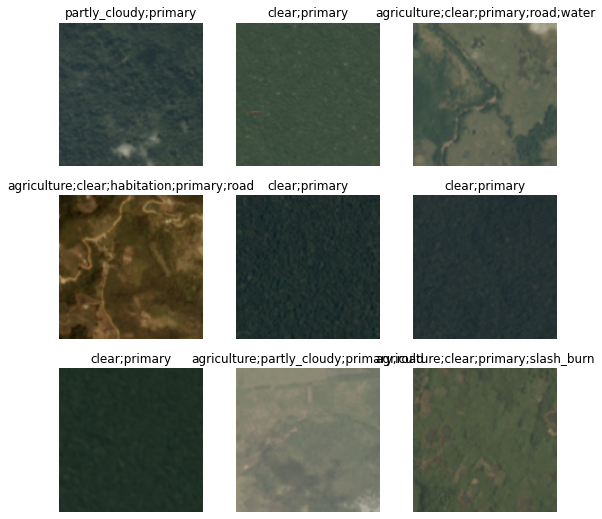

In [7]:
dls.show_batch()

**Train & Save ResNet-50 Model**

In [8]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta=2, average='samples', thresh=0.2)]
cbs = [MixUp]

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0005754399462603033)

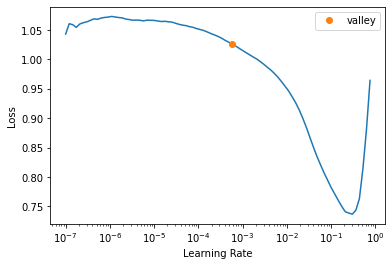

In [9]:
learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs).to_fp16()
learn.lr_find()

In [10]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

In [11]:
learn.save('resnet50-128')

Path('models/resnet50-128.pth')

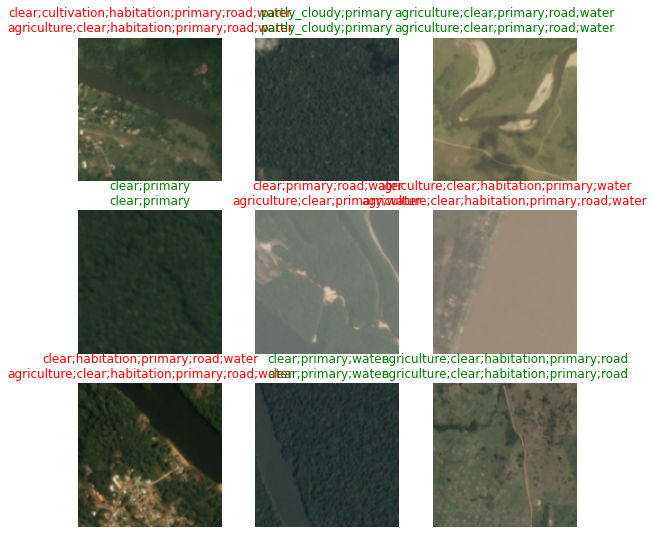

In [12]:
learn.show_results()